In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [6]:
df = pd.read_csv('US_Accidents_May19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

In [9]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [10]:
df[td][df[td]<=0]

69720      -0.0
69721      -0.0
69722      -0.0
69723      -1.0
69724      -1.0
309389    -30.0
309390    -30.0
746173    -30.0
746174    -31.0
1482940   -30.0
1483025   -30.0
1483026   -31.0
2038017   -31.0
Name: Time_Duration(min), dtype: float64

In [11]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [12]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [13]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [14]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 12424.0 minutes or 207 hours or 9 days; Min to clear an accident td: 1.0 minutes.


In [15]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

In [16]:
# Set the list of features to include in Machine Learning
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']


In [17]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 34 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Source              object 
 1   TMC                 float64
 2   Severity            float64
 3   Start_Lng           float64
 4   Start_Lat           float64
 5   Distance(mi)        float64
 6   Side                object 
 7   City                object 
 8   County              object 
 9   State               object 
 10  Timezone            object 
 11  Temperature(F)      float64
 12  Humidity(%)         float64
 13  Pressure(in)        float64
 14  Visibility(mi)      float64
 15  Wind_Direction      object 
 16  Weather_Condition   object 
 17  Amenity             object 
 18  Bump                object 
 19  Crossing            object 
 20  Give_Way            object 
 21  Junction            object 
 22  No_Exit             object 
 23  Railway             object 
 24  Roundabout          obje

In [18]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel.csv',index=False)


In [19]:
# Check missing values
df_sel.isnull().mean()

Source                0.000217
TMC                   0.230302
Severity              0.000217
Start_Lng             0.000217
Start_Lat             0.000217
Distance(mi)          0.000217
Side                  0.000217
City                  0.000248
County                0.000217
State                 0.000217
Timezone              0.001172
Temperature(F)        0.027943
Humidity(%)           0.028925
Pressure(in)          0.025724
Visibility(mi)        0.031997
Wind_Direction        0.021230
Weather_Condition     0.032285
Amenity               0.000217
Bump                  0.000217
Crossing              0.000217
Give_Way              0.000217
Junction              0.000217
No_Exit               0.000217
Railway               0.000217
Roundabout            0.000217
Station               0.000217
Stop                  0.000217
Traffic_Calming       0.000217
Traffic_Signal        0.000217
Turning_Loop          0.000217
Sunrise_Sunset        0.000252
Hour                  0.000217
Weekday 

In [20]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(1663631, 34)

In [21]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel_dropna.csv',index=False)

In [34]:
# Set state
state='PA'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63248 entries, 197866 to 1725073
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              63248 non-null  object 
 1   TMC                 63248 non-null  float64
 2   Severity            63248 non-null  float64
 3   Start_Lng           63248 non-null  float64
 4   Start_Lat           63248 non-null  float64
 5   Distance(mi)        63248 non-null  float64
 6   Side                63248 non-null  object 
 7   City                63248 non-null  object 
 8   County              63248 non-null  object 
 9   Timezone            63248 non-null  object 
 10  Temperature(F)      63248 non-null  float64
 11  Humidity(%)         63248 non-null  float64
 12  Pressure(in)        63248 non-null  float64
 13  Visibility(mi)      63248 non-null  float64
 14  Wind_Direction      63248 non-null  object 
 15  Weather_Condition   63248 non-null  object 
 1

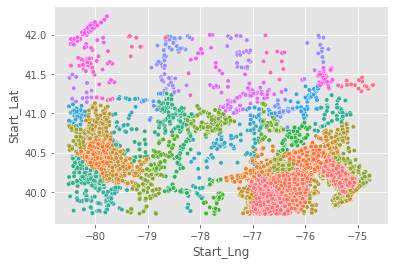

In [35]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

In [36]:
# Set county
county='Montgomery'

# Select the state of Pennsylvania
df_county=df_state.loc[df_state.County==county].copy()
df_county.drop('County',axis=1, inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              25206 non-null  object 
 1   TMC                 25206 non-null  float64
 2   Severity            25206 non-null  float64
 3   Start_Lng           25206 non-null  float64
 4   Start_Lat           25206 non-null  float64
 5   Distance(mi)        25206 non-null  float64
 6   Side                25206 non-null  object 
 7   City                25206 non-null  object 
 8   Timezone            25206 non-null  object 
 9   Temperature(F)      25206 non-null  float64
 10  Humidity(%)         25206 non-null  float64
 11  Pressure(in)        25206 non-null  float64
 12  Visibility(mi)      25206 non-null  float64
 13  Wind_Direction      25206 non-null  object 
 14  Weather_Condition   25206 non-null  object 
 15  Amenity             25206 non-null  object 
 1

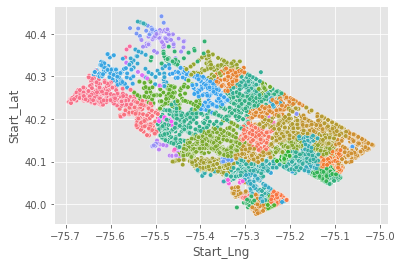

In [37]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
plt.show()

In [38]:
# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_county_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Columns: 137 entries, TMC to Weekday_Wed
dtypes: float64(11), uint8(126)
memory usage: 5.3 MB


In [39]:
# Assign the data
df=df_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [40]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [41]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.940.


/Users/marvinchang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))
[K-Nearest Neighbors (KNN)] knn.score: 0.935.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.935.

SyntaxError: invalid syntax (3525022218.py, line 18)

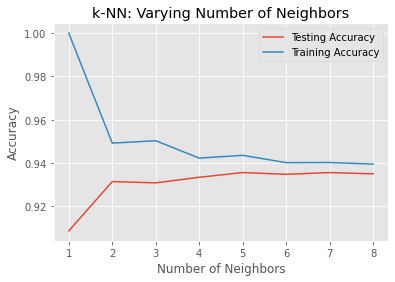

In [44]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [45]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.968.
[Decision Tree -- gini] accuracy_score: 0.968.


In [46]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.976.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


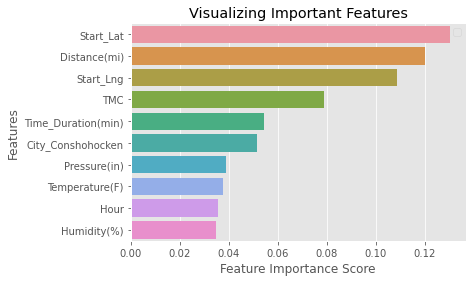

In [47]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [48]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lat                     0.130064
Distance(mi)                  0.120041
Start_Lng                     0.108720
TMC                           0.078951
Time_Duration(min)            0.054224
City_Conshohocken             0.051691
Pressure(in)                  0.038852
Temperature(F)                0.037579
Hour                          0.035811
Humidity(%)                   0.034716
Traffic_Signal_True           0.023654
Side_R                        0.023614
Junction_True                 0.015189
City_Bala Cynwyd              0.014981
City_King of Prussia          0.013824
Visibility(mi)                0.013650
City_Plymouth Meeting         0.013289
Weekday_Sun                   0.008669
City_Narberth                 0.008270
Weather_Condition_Overcast    0.007782
dtype: float64

In [49]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

TMC
Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Hour
Time_Duration(min)
City_Conshohocken


In [50]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [51]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.976.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.973.


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

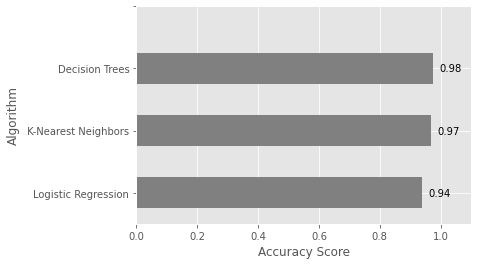

In [52]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?'.format(state, county))

plt.show()